<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu3/Minggu3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


---


Installing packages pandas, numpy, tqdm, sckit-learn, and pretrain model

In [ ]:
!pip install fair-esm -q
!pip install torch torchvision torchaudio
!pip install fair-esm scikit-learn pandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.6 MB/s eta 0:00:00


#Import Library


---


Importing Library from installed setup

In [ ]:
import torch
import pandas as pd
import numpy as np
import esm
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt

Save sequence train and test for ML with featured selected

#Load Checkpoints
Load embedding process for Deep learning and Machine learning

In [ ]:
# Deep learning
x_pdb_train_emb = torch.load("/content/PDB/x_pdb_train.pt").numpy()
y_pdb_train = np.load("/content/PDB/y_pdb_train.npy")

x_pdb_test_emb = torch.load("/content/PDB/x_pdb_test.pt").numpy()
y_pdb_test = np.load("/content/PDB/y_pdb_test.npy")

x_uni_train_emb = torch.load("/content/UNI/x_uni_train.pt").numpy()
y_uni_train = np.load("/content/UNI/y_uni_train.npy")

x_uni_test_emb = torch.load("/content/UNI/x_uni_test.pt").numpy()
y_uni_test = np.load("/content/UNI/y_uni_test.npy")

In [ ]:
print("=== PDB Dataset ===")
print("x_pdb_train_emb :", x_pdb_train_emb.shape)
print("y_pdb_train     :", y_pdb_train.shape)
print("x_pdb_test_emb  :", x_pdb_test_emb.shape)
print("y_pdb_test      :", y_pdb_test.shape)

print("\n=== UniSwiss Dataset ===")
print("x_uni_train_emb :", x_uni_train_emb.shape)
print("y_uni_train     :", y_uni_train.shape)
print("x_uni_test_emb  :", x_uni_test_emb.shape)
print("y_uni_test      :", y_uni_test.shape)


=== PDB Dataset ===
x_pdb_train_emb : (1060, 1280)
y_pdb_train     : (1060,)
x_pdb_test_emb  : (111, 1280)
y_pdb_test      : (111,)

=== UniSwiss Dataset ===
x_uni_train_emb : (8940, 1280)
y_uni_train     : (8940,)
x_uni_test_emb  : (756, 1280)
y_uni_test      : (756,)


Split Dataset

In [ ]:
x_pdb_train_new, x_pdb_val, y_pdb_train_new, y_pdb_val = train_test_split(
    x_pdb_train_emb, y_pdb_train, test_size=0.1, stratify=y_pdb_train, random_state=42
)

print("=== PDB Dataset ===")
print("Train:", x_pdb_train_new.shape, y_pdb_train_new.shape)
print("Val:  ", x_pdb_val.shape, y_pdb_val.shape)
print("Test: ", x_pdb_test_emb.shape, y_pdb_test.shape)

x_uni_train_new, x_uni_val, y_uni_train_new, y_uni_val = train_test_split(
    x_uni_train_emb, y_uni_train, test_size=0.1, stratify=y_uni_train, random_state=42
)

print("\n=== UNI Dataset ===")
print("Train:", x_uni_train_new.shape, y_uni_train_new.shape)
print("Val:  ", x_uni_val.shape, y_uni_val.shape)
print("Test: ", x_uni_test_emb.shape, y_uni_test.shape)

=== PDB Dataset ===
Train: (954, 1280) (954,)
Val:   (106, 1280) (106,)
Test:  (111, 1280) (111,)

=== UNI Dataset ===
Train: (8046, 1280) (8046,)
Val:   (894, 1280) (894,)
Test:  (756, 1280) (756,)


#Define Models
Define model with set hyperparamater/model architecture

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_dim=1280, n_filters=16, dropout=0.5, n_classes=2):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv1d(1, n_filters, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(n_filters)

        # Block 2
        self.conv2 = nn.Conv1d(n_filters, n_filters*2, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(n_filters*2)

        # Block 3
        #self.conv3 = nn.Conv1d(n_filters*2, n_filters*4, kernel_size=3, padding=1)
        #self.bn3 = nn.BatchNorm1d(n_filters*4)

        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # After 3x pooling:
        # 1280 → 640 → 320 → 160
        flattened = (input_dim // 8) * (n_filters * 4)

        self.fc1 = nn.Linear(flattened, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))   # (32 filters)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))   # (64 filters)
        #x = self.pool(self.relu(self.bn3(self.conv3(x))))   # (128 filters)
        x = x.view(x.size(0), -1)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x, None

def define_model(model_type, input_dim=1280, n_filters=32, dropout=0.5, n_classes=2):
    if model_type == "CNN":
        return CNNModel(input_dim, n_filters, dropout, n_classes)




NameError: name 'nn' is not defined

In [ ]:
def train_model(model_type=None, train_data=None, val_data=None, val_labels=None,
                train_labels=None, batch_size=32, epochs=10, learning_rate=0.001,
                n_filters=16, kernel_size=3, dropout=0.5):

    input_dim = train_data.shape[1]
    n_classes = len(np.unique(train_labels))

    model = define_model(model_type=model_type, input_dim=input_dim, n_classes=n_classes,
                         dropout=dropout, n_filters=n_filters)

    # Print model architecture
    print("Model architecture:")
    print(model)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {total_params}")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Convert tensor
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
    val_data_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long).to(device)

    if model_type == 'CNN':
        train_data_tensor = train_data_tensor.unsqueeze(1)
        val_data_tensor = val_data_tensor.unsqueeze(1)

    train_losses = []
    val_losses = []
    val_accuracies = []

    # ---- BATCH TRAINING (BENAR) ----
    num_samples = train_data_tensor.size(0)
    num_batches = int(np.ceil(num_samples / batch_size))

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

 # Shuffle data each epoch
        indices = torch.randperm(num_samples)
        shuffled_data = train_data_tensor[indices]
        shuffled_labels = train_labels_tensor[indices]

        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, num_samples)

            batch_x = shuffled_data[start:end]
            batch_y = shuffled_labels[start:end]

            outputs, _ = model(batch_x)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / num_batches)

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs, _ = model(val_data_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)
            val_losses.append(val_loss.item())

            _, predicted = torch.max(val_outputs, 1)
            acc = (predicted == val_labels_tensor).float().mean().item()
            val_accuracies.append(acc)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss/num_batches:.4f}, Val Acc: {acc*100:.2f}%")

    return model, train_losses, val_losses, val_accuracies


In [ ]:
def set_seed(seed=42):
    """Sets the random seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For all GPUs
    torch.cuda.manual_seed_all(seed) # For all GPUs

    # Ensures that CUDA operations are deterministic even if they might be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed} for reproducibility.")


Feel free do some experiment below with hyperparameter

In [ ]:
set_seed(42)
print("Training CNN model...")

print("Training CNN model on PDB...")
trained_pdb_model, pdb_train_losses, pdb_val_losses, pdb_val_accuracies = train_model(
    model_type='CNN',
    train_data=x_pdb_train_new,
    train_labels=y_pdb_train_new,
    val_data=x_pdb_val,
    val_labels=y_pdb_val,
    epochs=50,
    learning_rate=0.001,  # Increased learning rate
    n_filters=16,        # Use n_filters instead of hidden_dim
    dropout=0.5
)

print("Training CNN model on UNI...")
trained_uni_model, uni_train_losses, uni_val_losses, uni_val_accuracies = train_model(
    model_type='CNN',
    train_data=x_uni_train_new,
    train_labels=y_uni_train_new,
    val_data=x_uni_val,
    val_labels=y_uni_val,
    epochs=50,
    learning_rate=0.001,
    n_filters=16,
    dropout=0.5
)

Random seed set to 42 for reproducibility.
Training CNN model...
Training CNN model on PDB...


NameError: name 'define_model' is not defined

#Evaluate and Visualize
Evaluate model
>

Visualize histogram
>

Visualize Confusion Matrix
>

In [ ]:
def evaluate_model(model, X_test, y_test, model_type, dataset_name):
    model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Reshape data for CNN
    X_test_tensor = X_test_tensor.unsqueeze(1)
    with torch.no_grad():
           outputs, _ = model(X_test_tensor)
    y_pred_probs = []
    y_preds = []

    y_pred_probs = outputs.cpu().numpy()
    _, predicted_labels = torch.max(outputs, 1)
    y_preds = predicted_labels.cpu().numpy()

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    mcc = matthews_corrcoef(y_test, y_preds)
    roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1]) # Assuming binary classification and prob of class 1

    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    specificity = tn / (tn + fp)

    metrics_dict = {
        "Model": model_type,
        "Dataset": dataset_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1": f1,
        "MCC": mcc,
        "ROC_AUC": roc_auc
    }

    print(f"\nEvaluation for {model_type} on {dataset_name} dataset:")
    print(f"Accuracy: {acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | ROC_AUC: {roc_auc:.3f}")

    return metrics_dict, y_preds, y_pred_probs

In [ ]:
# Function to visualize the confusion matrix and ROC curve
def visualize_metrics(y_true_pdb, y_pred_pdb, y_prob_pdb, y_true_uni, y_pred_uni, y_prob_uni, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true_pdb, y_pred_pdb, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true_uni, y_pred_uni, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(y_true_pdb, y_prob_pdb[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true_uni, y_prob_uni[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_losses(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

### Deep Learning Model Evaluation Example


Evaluation for CNN on PDB dataset:
Accuracy: 0.858 | Precision: 0.878 | Recall: 0.827 | F1: 0.851 | ROC_AUC: 0.939

Evaluation for CNN on UniSwiss dataset:
Accuracy: 0.906 | Precision: 0.905 | Recall: 0.905 | F1: 0.905 | ROC_AUC: 0.959


,Model,Dataset,Accuracy,Precision,Recall,Specificity,F1,MCC,ROC_AUC
0,CNN,PDB,0.858491,0.877551,0.826923,0.888889,0.851485,0.717732,0.939103
1,CNN,UniSwiss,0.906040,0.905405,0.905405,0.906667,0.905405,0.812072,0.958969


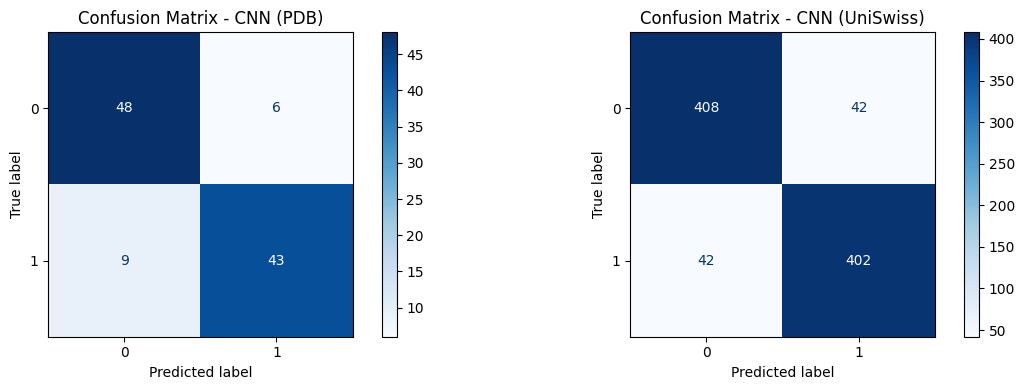

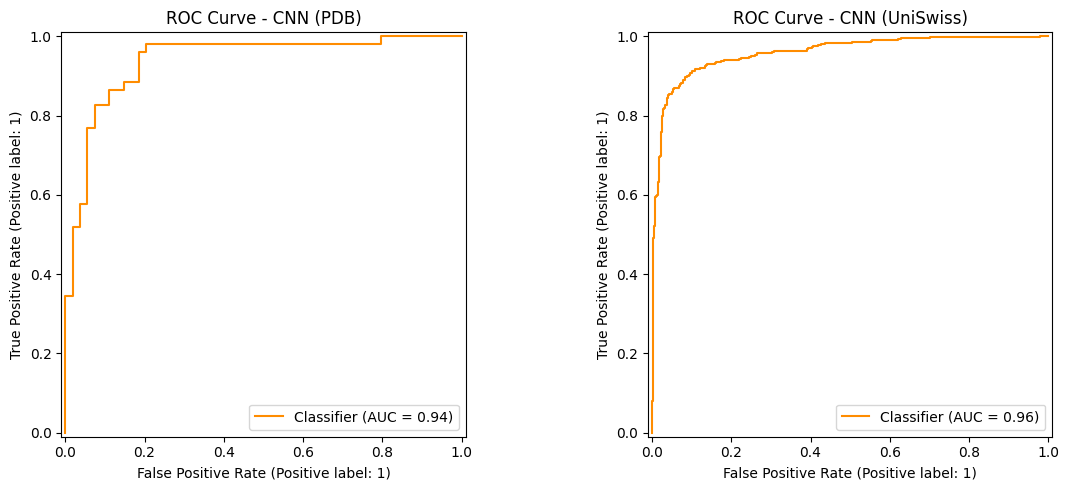

In [ ]:
# Assuming 'trained_pdb_model_exp1' and 'trained_uni_model' from the BiLSTM training cell are available.
# If you trained a different DL model, replace these variable names and 'model_type' accordingly.

# Evaluate PDB CNN model
pdb_CNN_metrics, y_pred_pdb_CNN, y_prob_pdb_CNN = evaluate_model(
    trained_pdb_model, x_pdb_val, y_pdb_val, model_type='CNN', dataset_name="PDB"
)

# Evaluate UniSwiss CNN model
uni_CNN_metrics, y_pred_uni_CNN, y_prob_uni_CNN = evaluate_model(
    trained_uni_model, x_uni_val, y_uni_val, model_type='CNN', dataset_name="UniSwiss"
)

# Display results table
CNN_results_df = pd.DataFrame([pdb_CNN_metrics, uni_CNN_metrics])
display(CNN_results_df)

# Visualize metrics for CNN
visualize_metrics(
    y_pdb_val, y_pred_pdb_CNN, y_prob_pdb_CNN,
    y_uni_val, y_pred_uni_CNN, y_prob_uni_CNN,
    model_name="CNN"
)

### Plotting BiLSTM Model Losses

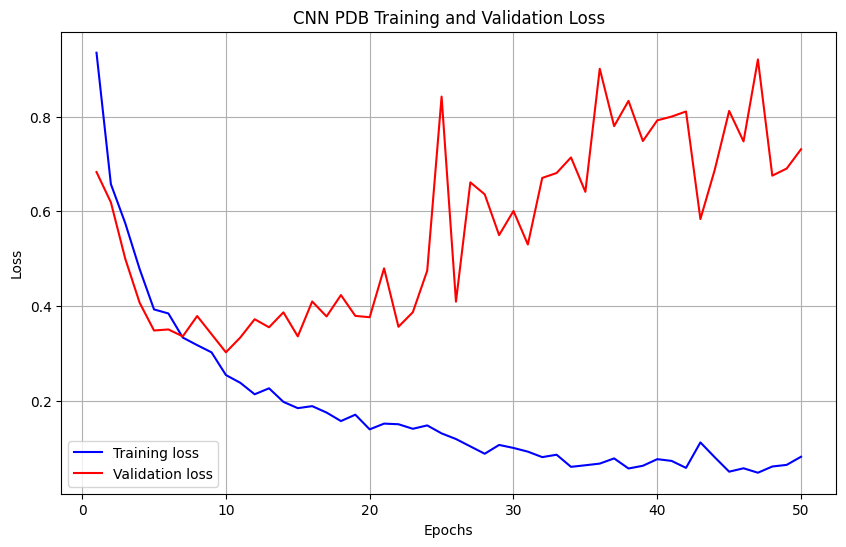

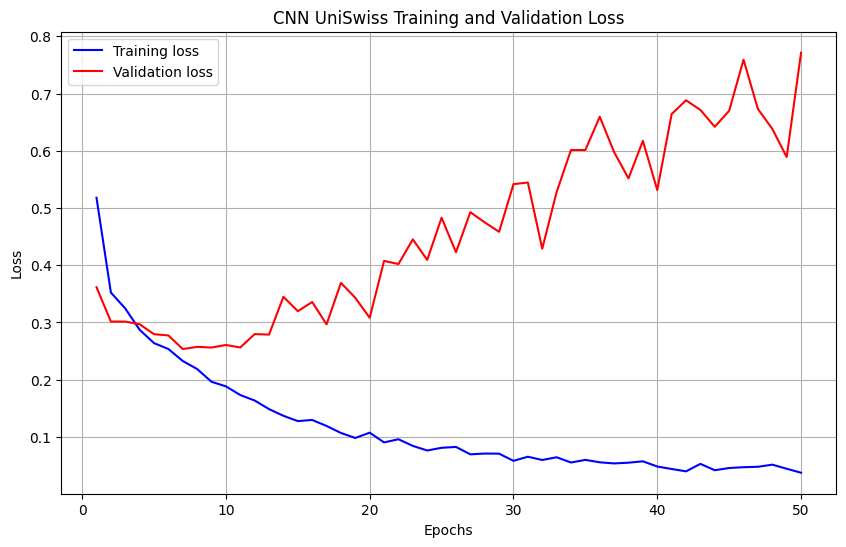

In [ ]:
plot_losses(pdb_train_losses, pdb_val_losses, 'CNN PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'CNN UniSwiss Training and Validation Loss')

Test

In [ ]:
# === EVALUATE TEST SET ===

print("\nEvaluating on PDB TEST set...")
pdb_CNN_test_metrics, y_pred_pdb_test, y_prob_pdb_test = evaluate_model(
    trained_pdb_model,
    x_pdb_test_emb,
    y_pdb_test,
    model_type='CNN',
    dataset_name="PDB TEST"
)

print("\nEvaluating on UniSwiss TEST set...")
uni_CNN_test_metrics, y_pred_uni_test, y_prob_uni_test = evaluate_model(
    trained_uni_model,
    x_uni_test_emb,
    y_uni_test,
    model_type='CNN',
    dataset_name="UniSwiss TEST"
)

# Display results table
test_results_df = pd.DataFrame([pdb_CNN_test_metrics, uni_CNN_test_metrics])
display(test_results_df)



Evaluating on PDB TEST set...

Evaluation for CNN on PDB TEST dataset:
Accuracy: 0.811 | Precision: 0.448 | Recall: 0.722 | F1: 0.553 | ROC_AUC: 0.879

Evaluating on UniSwiss TEST set...

Evaluation for CNN on UniSwiss TEST dataset:
Accuracy: 0.905 | Precision: 0.927 | Recall: 0.877 | F1: 0.901 | ROC_AUC: 0.954


,Model,Dataset,Accuracy,Precision,Recall,Specificity,F1,MCC,ROC_AUC
0,CNN,PDB TEST,0.810811,0.448276,0.722222,0.827957,0.553191,0.461611,0.878734
1,CNN,UniSwiss TEST,0.904762,0.926761,0.877333,0.931759,0.901370,0.810568,0.954352


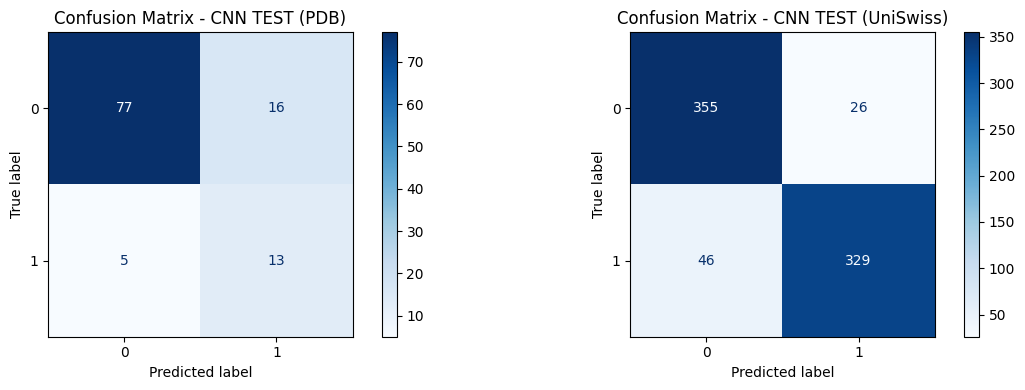

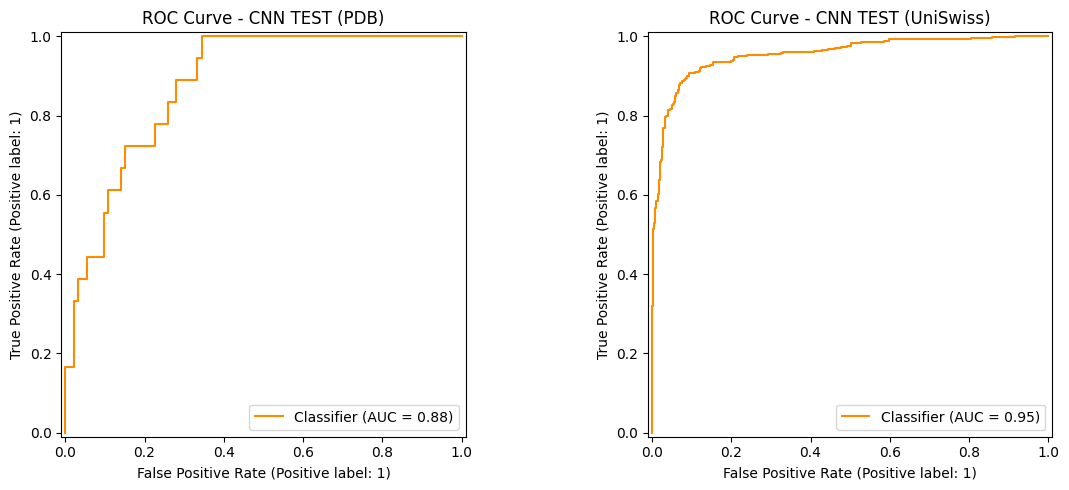

In [ ]:
visualize_metrics(
    y_pdb_test, y_pred_pdb_test, y_prob_pdb_test,
    y_uni_test, y_pred_uni_test, y_prob_uni_test,
    model_name="CNN TEST"
)


In [ ]:
.